# Апробация моделей частотных сканов на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## 0. Импорт модулей

In [2]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from pydlts.fsmodels import SklMultiExpFrequencyScan, SklSingleExpFrequencyScan

from pydlts.fsplots import plot_experimental_points
from pydlts.fsplots import plot_spectr
from pydlts.fsplots import plot_model
from pydlts.fsplots import plot_loss_path
from pydlts.fsplots import plot_deviations

%matplotlib inline

## 1. Чтение данных

In [3]:
DATASETS_PATH = '../datasets/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [4]:
file_names = listdir(DATASETS_PATH)

### 1.1. Выберем данные полученные при $U_1 = -4$ В и $U_R = -5$ В
Данному критерию соответствуют 3 частотных скана

In [5]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASETS_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [6]:
len(data_frames)

3

Отсортируем частотные сканы по температуре в начале сканирования

In [7]:
key_func = lambda x: x[1].temperature_k.iloc[0]
data_frames.sort(key=key_func)

for i, item in enumerate(data_frames):
    print(f'{i}.', item[0])

0. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv
1. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv
2. 1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = -10^\circ C$

In [8]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [9]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +10^\circ C$

In [10]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [11]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +30^\circ C$

In [12]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 34 точки. Данные не содержат пропусков.

In [13]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_-10С\_-4В-5В\_10мВ\_10мкс\_шаг\_0,01.csv.csv
### 2.1. Подготовка экспериментальных данных

Чтение данных

In [14]:
print(data_frames[0][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


In [15]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    X = np.log10(dataset.frequency_hz.to_numpy())
    y = dataset.dlts_pf.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    
    return filling_pulse, X_train, y_train, X_test, y_test

In [16]:
filling_pulse, X_train, y_train, X_test, y_test = get_X_y(data_frames[0][1])

Выведем тренировачный набор данных

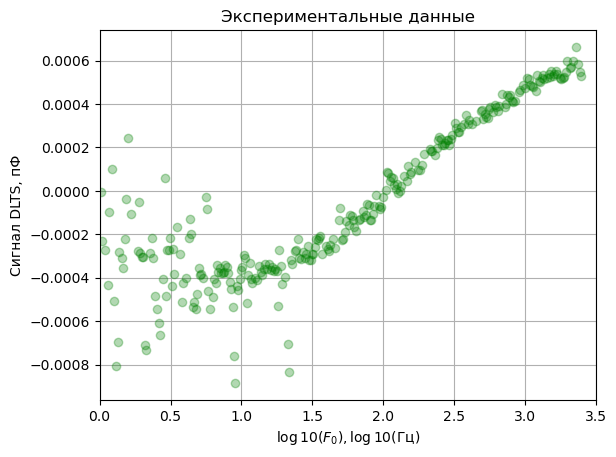

In [17]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_train_data.pdf',
            bbox_inches='tight')
plt.show()

Выведем тестовый набор данных

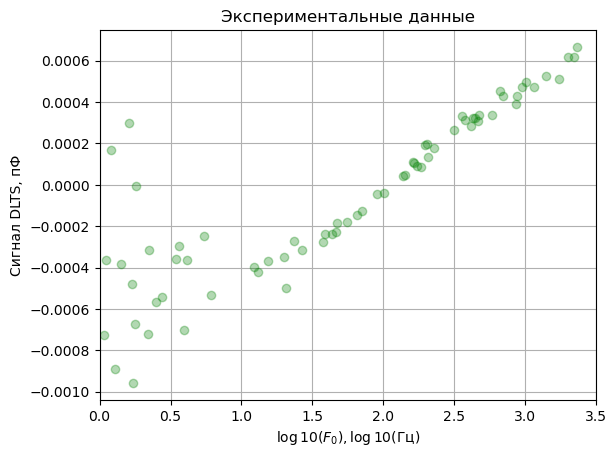

In [18]:
fig, ax = plot_experimental_points(X_test, y_test)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_test_data.pdf',
            bbox_inches='tight')
plt.show()

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$
Идентификация модели:

In [19]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-3.0, 0.0002]])

2022-10-08 13:48:32.185365: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 13:48:32.185388: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 13:48:32.185392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 13:48:32.185523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 13:48:32.185535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 13:48:32.185539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 13:48:32.185990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [20]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pkl']

Вывод табличных результатов идентификации

In [21]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_fit_results_1.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
225,0.000533,0.00001,True,0.05,7.902869e-08,1,1000,0.810602,0.00001,-3.536037,False
226,0.000533,0.00001,True,0.05,7.902792e-08,1,1000,0.810239,0.00001,-3.536316,False
227,0.000533,0.00001,True,0.05,7.902715e-08,1,1000,0.809876,0.00001,-3.536594,False
228,0.000533,0.00001,True,0.05,7.902640e-08,1,1000,0.809514,0.00001,-3.536869,False
229,0.000533,0.00001,True,0.05,7.902567e-08,1,1000,0.809152,0.00001,-3.537143,False
230,0.000533,0.00001,True,0.05,7.902495e-08,1,1000,0.808791,0.00001,-3.537415,False
231,0.000534,0.00001,True,0.05,7.902424e-08,1,1000,0.808431,0.00001,-3.537685,False
232,0.000534,0.00001,True,0.05,7.902354e-08,1,1000,0.808071,0.00001,-3.537954,False
233,0.000534,0.00001,True,0.05,7.902286e-08,1,1000,0.807713,0.00001,-3.538220,False
234,0.000534,0.00001,True,0.05,7.902219e-08,1,1000,0.807354,0.00001,-3.538485,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

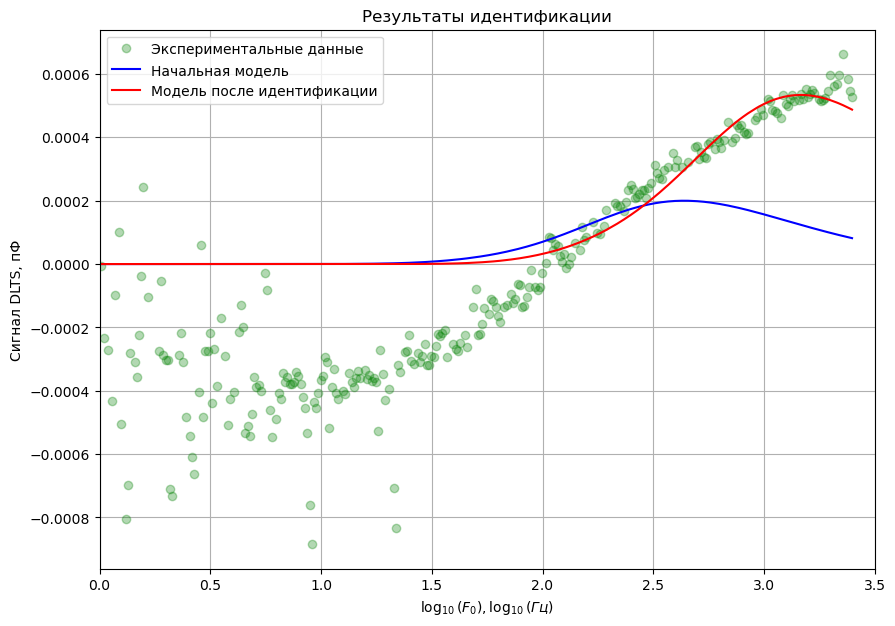

In [22]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

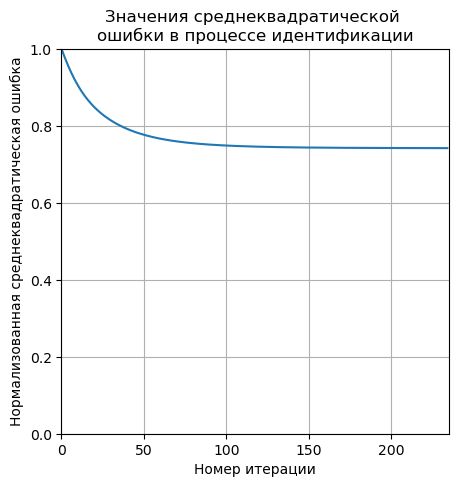

In [23]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_loss_1.pdf',
            bbox_inches='tight')
plt.show()

График выходит на "плато", что свидетельствует о том, что решение сошлось, однако довольно высокое значение среднеквадратической ошибки может указывать на то, что алгоритм нашёл локальный минимум функции потерь. О последнем также свидетельсвует предыдущий график (графика с экспериментальными данными и данными полученными на идентифицированной модели).

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

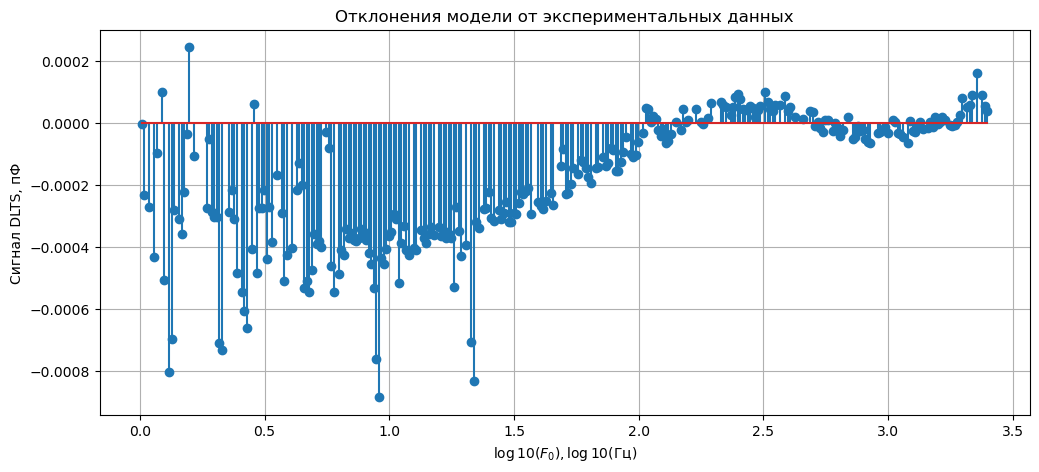

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_deviations_1.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

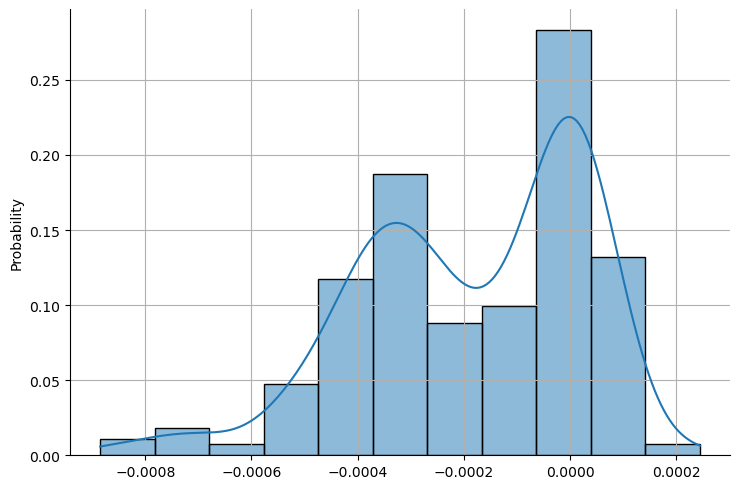

In [25]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_hist_1.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [26]:
def display_scores(scores):
    print('Scores - корни из среднеквадратических ошибок')
    scores = np.sqrt(-scores)
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [27]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-3.0, 0.0002]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 13:49:04.867188: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 13:49:04.867210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 13:49:04.867214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 13:49:04.867321: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 13:49:04.867335: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 13:49:04.867338: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 13:49:04.867452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00029281 0.00029454 0.0002831  0.0002712  0.00026233]
Mean: 0.0002807966237032519
Standard deviation: 1.2421250363559893e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [28]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00028110886269098665

Оценим ту же метрику на тестовых данных

In [29]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00032577379513290555

Выведем на экран полученный спектр

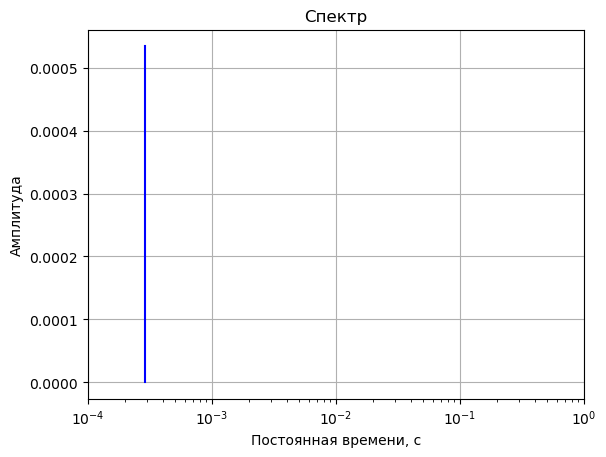

In [30]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_spectr_1.pdf',
            bbox_inches='tight')
plt.show()

Попробуем идентифицировать модель задав другую начальную точку для идентификации.

Идентификация модели с начальной точкой близкой к отрицательному пику

In [31]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-1.5, -0.0002]])

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраим модель

In [32]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pkl']

Вывод табличных результатов идентификации

In [33]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_fit_results_2.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
165,-0.000464,0.00001,True,0.05,7.616906e-08,1,1000,1.098484,0.00001,-1.112102,False
166,-0.000465,0.00001,True,0.05,7.616821e-08,1,1000,1.099008,0.00001,-1.112184,False
167,-0.000465,0.00001,True,0.05,7.616738e-08,1,1000,1.099525,0.00001,-1.112265,False
168,-0.000465,0.00001,True,0.05,7.616658e-08,1,1000,1.100036,0.00001,-1.112344,False
169,-0.000465,0.00001,True,0.05,7.616580e-08,1,1000,1.100539,0.00001,-1.112423,False
170,-0.000465,0.00001,True,0.05,7.616504e-08,1,1000,1.101036,0.00001,-1.112501,False
171,-0.000465,0.00001,True,0.05,7.616431e-08,1,1000,1.101526,0.00001,-1.112577,False
172,-0.000466,0.00001,True,0.05,7.616361e-08,1,1000,1.102010,0.00001,-1.112653,False
173,-0.000466,0.00001,True,0.05,7.616292e-08,1,1000,1.102487,0.00001,-1.112728,False
174,-0.000466,0.00001,True,0.05,7.616226e-08,1,1000,1.102957,0.00001,-1.112802,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

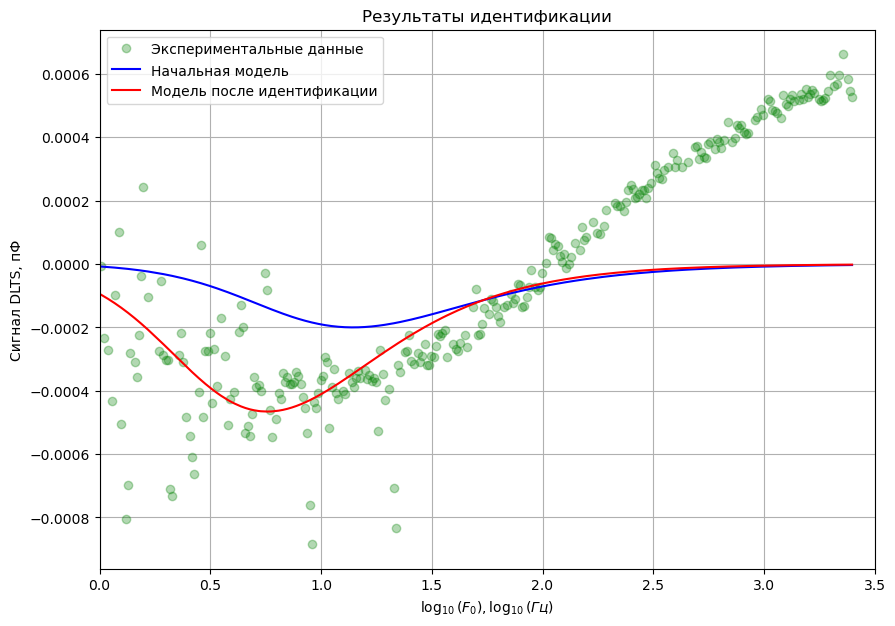

In [34]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

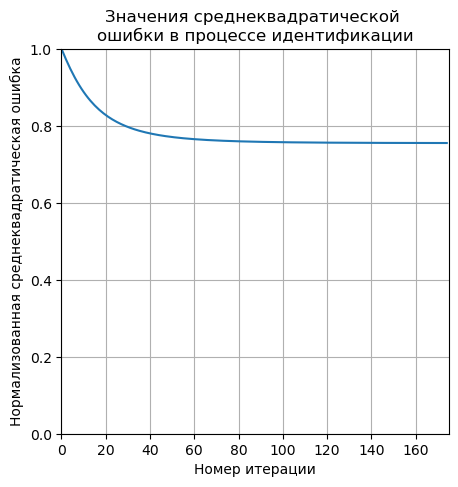

In [35]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_loss_2.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

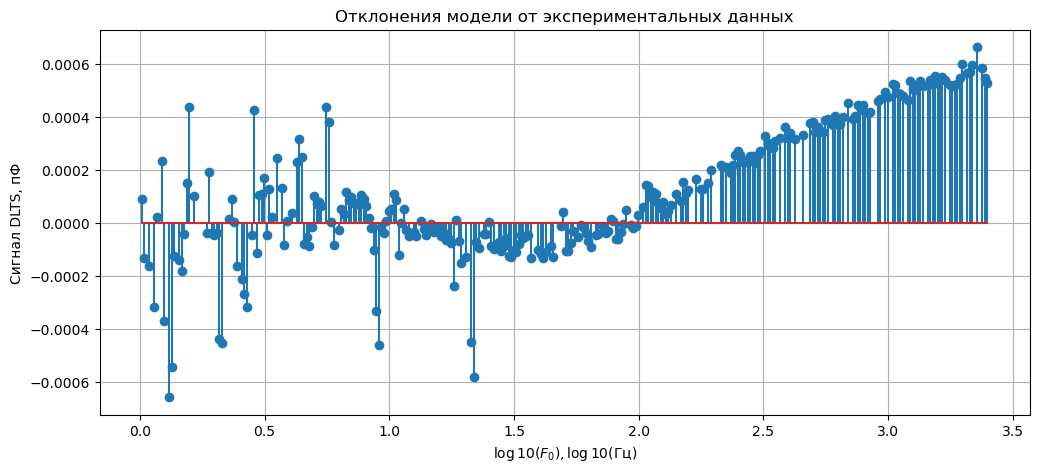

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_deviations_2.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

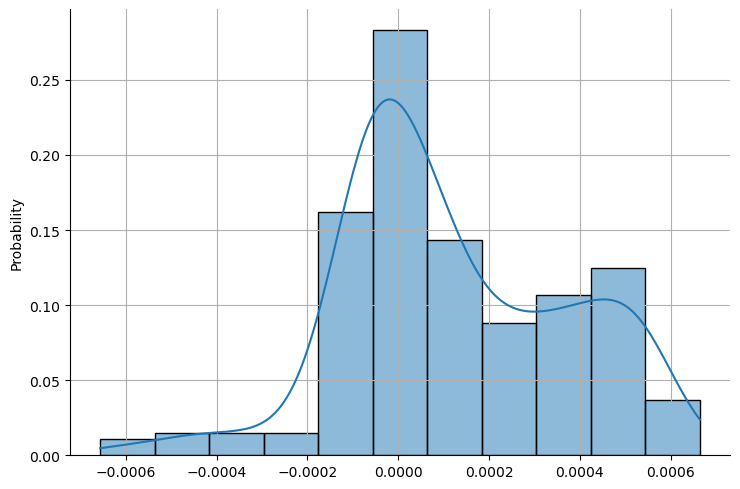

In [37]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_hist_2.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [38]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-1.5, -0.0002]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 13:50:05.430772: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 13:50:05.430796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 13:50:05.430800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 13:50:05.430908: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 13:50:05.430921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 13:50:05.430925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 13:50:05.431030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00030161 0.00022981 0.00031517 0.00026068 0.00028272]
Mean: 0.0002779953774609912
Standard deviation: 3.027575076160385e-05


Оценим корень из среднеквадратической ошики между экспериментальными данными и данными, полученными на идентифицированной модели

In [39]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00027597509962941266

Оценим ту же метрику на тестовых данных

In [40]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00032653888665531245

Выведем на экран полученный спектр

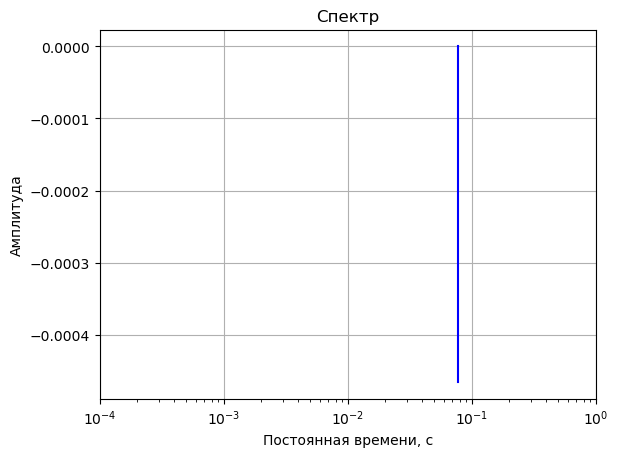

In [41]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_spectr_2.pdf',
            bbox_inches='tight')
plt.show()

### 2.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [42]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [43]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [44]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
170,-0.000451,0.00001,False,0.05,7.643864e-08,1,1000,1.0,0.00001,-1.095010,False
171,-0.000451,0.00001,False,0.05,7.643762e-08,1,1000,1.0,0.00001,-1.094948,False
172,-0.000452,0.00001,False,0.05,7.643666e-08,1,1000,1.0,0.00001,-1.094887,False
173,-0.000452,0.00001,False,0.05,7.643575e-08,1,1000,1.0,0.00001,-1.094829,False
174,-0.000452,0.00001,False,0.05,7.643489e-08,1,1000,1.0,0.00001,-1.094772,False
175,-0.000452,0.00001,False,0.05,7.643408e-08,1,1000,1.0,0.00001,-1.094716,False
176,-0.000453,0.00001,False,0.05,7.643331e-08,1,1000,1.0,0.00001,-1.094662,False
177,-0.000453,0.00001,False,0.05,7.643258e-08,1,1000,1.0,0.00001,-1.094610,False
178,-0.000453,0.00001,False,0.05,7.643189e-08,1,1000,1.0,0.00001,-1.094558,False
179,-0.000453,0.00001,False,0.05,7.643124e-08,1,1000,1.0,0.00001,-1.094509,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

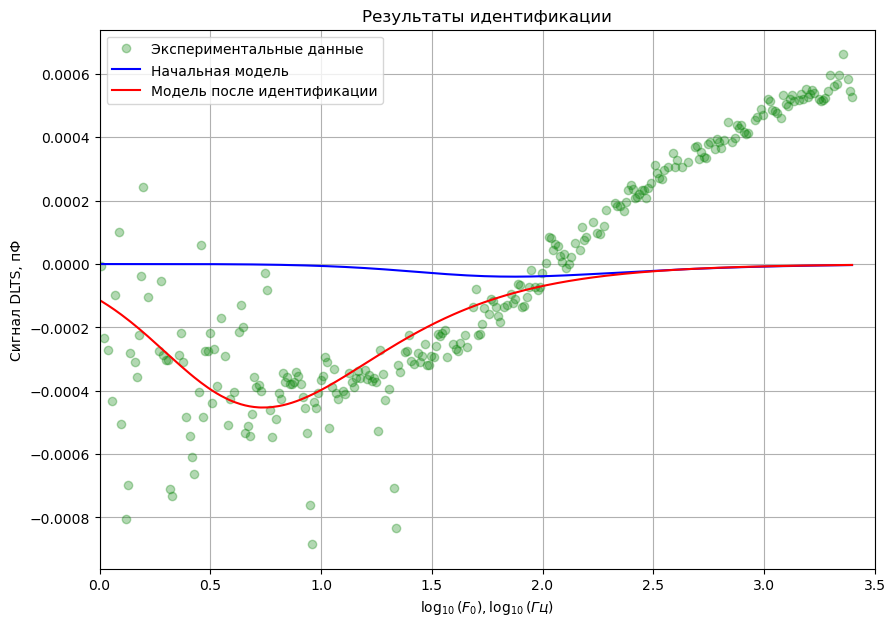

In [45]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

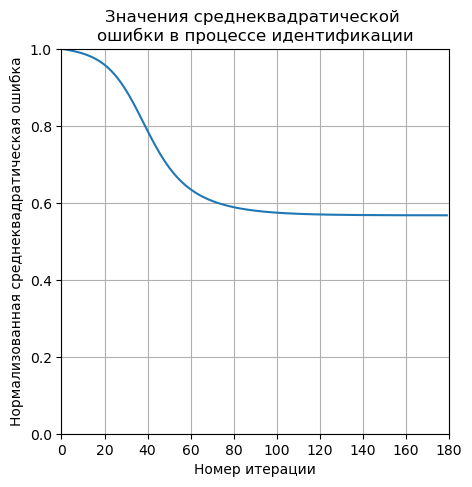

In [46]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

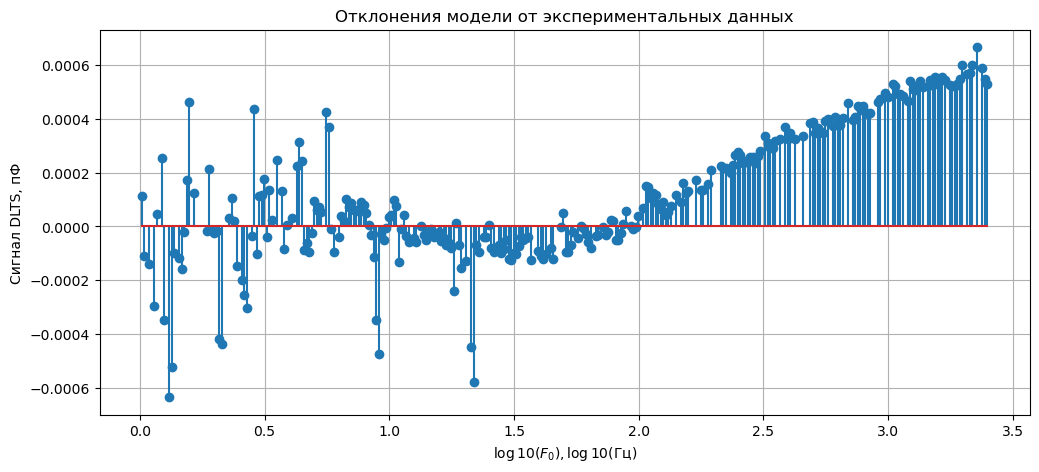

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

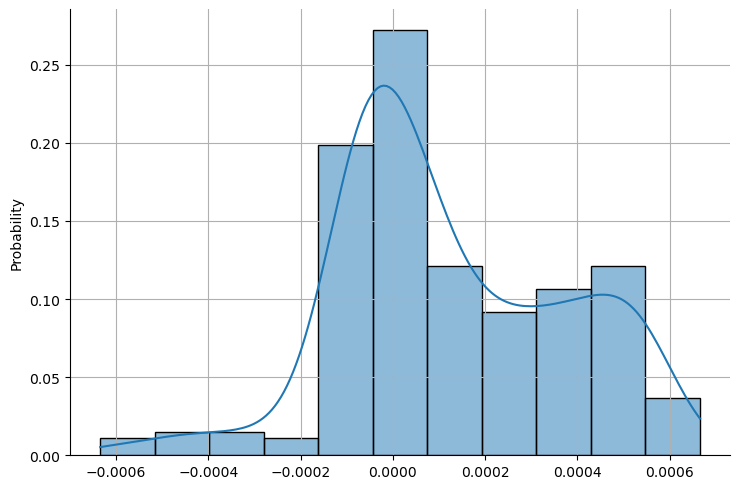

In [48]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [49]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 13:50:57.646065: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 13:50:57.646089: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 13:50:57.646092: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 13:50:57.646196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 13:50:57.646209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 13:50:57.646212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 13:50:57.646314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00029318 0.00022736 0.0002839  0.00026153 0.00028126]
Mean: 0.00026944560217721883
Standard deviation: 2.3434174789931816e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [50]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00027646199999129965

Оценим ту же метрику на тестовых данных

In [51]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00032529221911277185

Выведем на экран полученный спектр

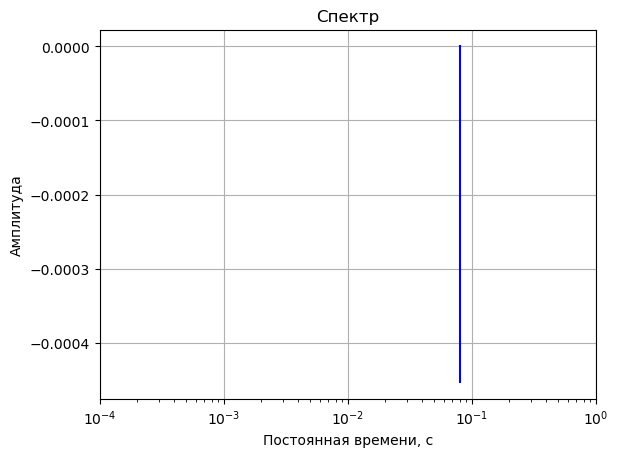

In [52]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [53]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [54]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [55]:
grid_search.fit(X_train, y_train)

2022-10-08 13:51:34.699322: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 13:51:34.699468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 13:51:34.699477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 13:51:34.699725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 13:51:34.699780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 13:51:34.699808: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 13:51:34.700042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [56]:
grid_search.best_params_

{'n_exps': 6}

Сохраним объект GridSearchCV

In [57]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.00029142911644875185 {'n_exps': 1}
0.00020782764193633406 {'n_exps': 2}
0.00021591208205758717 {'n_exps': 3}
0.00012587260409548885 {'n_exps': 4}
0.00012601464020680475 {'n_exps': 5}
0.0001207000268302703 {'n_exps': 6}
0.00012205968911706009 {'n_exps': 7}
0.00012389028263687499 {'n_exps': 8}
0.00012159464608021991 {'n_exps': 9}
0.00012252844996840453 {'n_exps': 10}


Сохраним лучшую модель

In [59]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [60]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
407,-0.000156,0.000123,0.000208,-0.000219,0.000372,-0.000211,0.00001,0.05,1.327310e-08,6,1000,0.00001,-1.118406,-2.755456,-3.232851,-1.665686,-3.809697,-0.639798,False
408,-0.000156,0.000123,0.000208,-0.000219,0.000372,-0.000211,0.00001,0.05,1.327238e-08,6,1000,0.00001,-1.118528,-2.755363,-3.232897,-1.665668,-3.809978,-0.639432,False
409,-0.000156,0.000124,0.000208,-0.000219,0.000372,-0.000211,0.00001,0.05,1.327166e-08,6,1000,0.00001,-1.118650,-2.755271,-3.232943,-1.665649,-3.810258,-0.639068,False
410,-0.000156,0.000124,0.000208,-0.000219,0.000372,-0.000211,0.00001,0.05,1.327095e-08,6,1000,0.00001,-1.118771,-2.755179,-3.232989,-1.665630,-3.810536,-0.638705,False
411,-0.000156,0.000124,0.000208,-0.000219,0.000372,-0.000211,0.00001,0.05,1.327024e-08,6,1000,0.00001,-1.118891,-2.755087,-3.233035,-1.665611,-3.810813,-0.638344,False
412,-0.000156,0.000124,0.000208,-0.000219,0.000372,-0.000211,0.00001,0.05,1.326954e-08,6,1000,0.00001,-1.119011,-2.754996,-3.233082,-1.665591,-3.811089,-0.637984,False
413,-0.000156,0.000124,0.000208,-0.000219,0.000373,-0.000211,0.00001,0.05,1.326885e-08,6,1000,0.00001,-1.119130,-2.754905,-3.233129,-1.665572,-3.811364,-0.637626,False
414,-0.000156,0.000124,0.000208,-0.000219,0.000373,-0.000211,0.00001,0.05,1.326816e-08,6,1000,0.00001,-1.119249,-2.754814,-3.233176,-1.665552,-3.811637,-0.637269,False
415,-0.000156,0.000124,0.000208,-0.000219,0.000373,-0.000212,0.00001,0.05,1.326747e-08,6,1000,0.00001,-1.119367,-2.754724,-3.233223,-1.665532,-3.811909,-0.636914,False
416,-0.000156,0.000124,0.000208,-0.000219,0.000373,-0.000212,0.00001,0.05,1.326680e-08,6,1000,0.00001,-1.119485,-2.754634,-3.233270,-1.665512,-3.812180,-0.636561,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

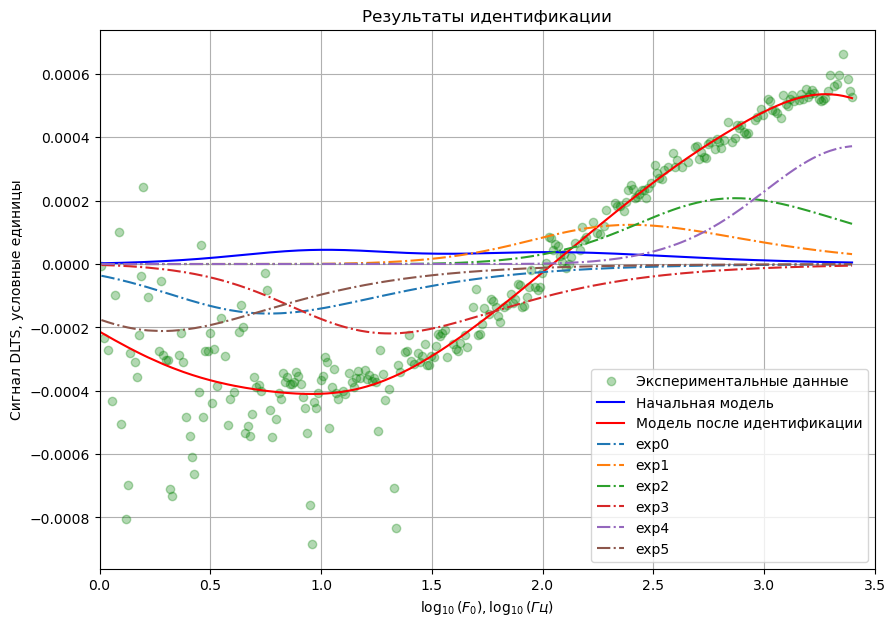

In [61]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

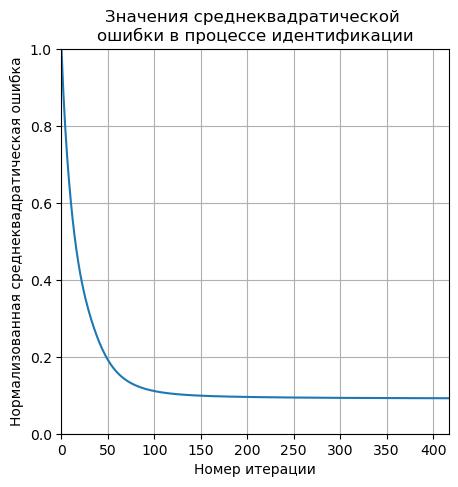

In [62]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [63]:
y_pred = multiexp_fs.predict(X_train)

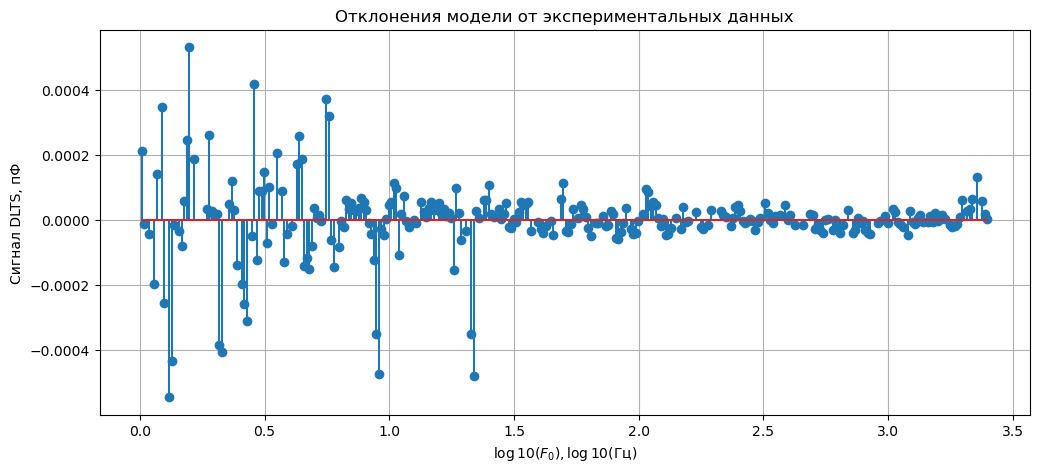

In [64]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

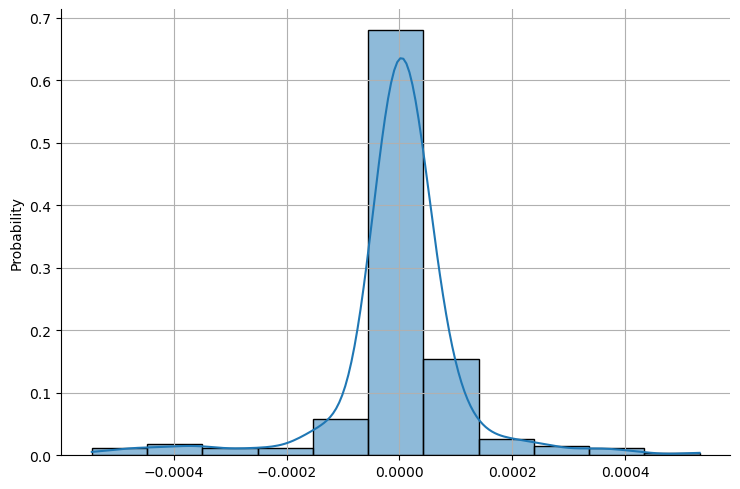

In [65]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [66]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 14:25:53.645232: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 14:25:53.645254: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 14:25:53.645258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 14:25:53.645360: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 14:25:53.645373: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 14:25:53.645376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 14:25:53.645476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00011688 0.00010575 0.00015515 0.00012239 0.00010592]
Mean: 0.00012122077246926322
Standard deviation: 1.8138376293433077e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [67]:
mean_squared_error(y_train, y_pred, squared=False)

0.00011518158185991337

Оценим ту же метрику на тестовых данных

In [68]:
mean_squared_error(y_test, multiexp_fs.predict(X_test), squared=False)

0.00018640344594129347

Выведем на экран полученный спектр

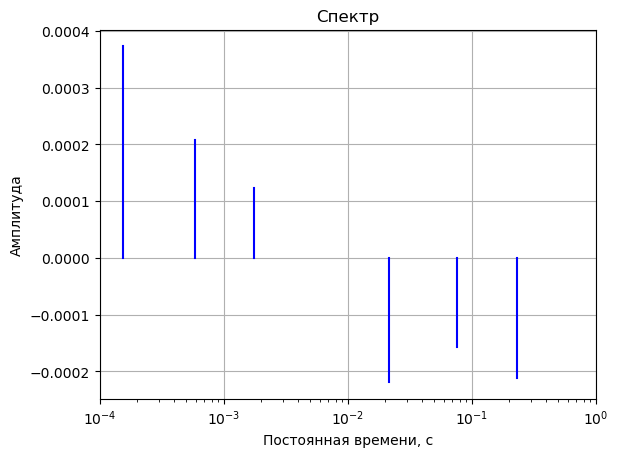

In [69]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [70]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps=5,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [71]:
initial_exps_params = [[-3.0, 0.0002], 
                       [-3.5, 0.0004],
                       [-1.5, -0.0002],
                       [-1.0, -0.0002],
                       [-2.0, -0.0002]
                      ]
multiexp_fs.fit(X_train, y_train, initial_exps_params_=initial_exps_params)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, n_exps=5, stop_val=1e-05)

In [72]:
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,verbose
229,0.00024,0.000455,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325680e-08,5,1000,0.00001,-2.870671,-3.713657,-1.315852,-0.658963,-1.782985,False
230,0.00024,0.000455,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325607e-08,5,1000,0.00001,-2.870778,-3.713914,-1.316055,-0.658622,-1.782665,False
231,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325534e-08,5,1000,0.00001,-2.870885,-3.714169,-1.316257,-0.658283,-1.782346,False
232,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325462e-08,5,1000,0.00001,-2.870992,-3.714423,-1.316457,-0.657946,-1.782029,False
233,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325391e-08,5,1000,0.00001,-2.871098,-3.714676,-1.316657,-0.657612,-1.781712,False
234,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325320e-08,5,1000,0.00001,-2.871205,-3.714927,-1.316855,-0.657280,-1.781398,False
235,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325251e-08,5,1000,0.00001,-2.871312,-3.715177,-1.317052,-0.656951,-1.781084,False
236,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325182e-08,5,1000,0.00001,-2.871419,-3.715426,-1.317248,-0.656623,-1.780772,False
237,0.00024,0.000456,-0.000196,-0.000248,-0.000153,0.00001,0.05,1.325114e-08,5,1000,0.00001,-2.871526,-3.715673,-1.317443,-0.656299,-1.780461,False
238,0.00024,0.000456,-0.000196,-0.000248,-0.000153,0.00001,0.05,1.325047e-08,5,1000,0.00001,-2.871633,-3.715919,-1.317637,-0.655976,-1.780152,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

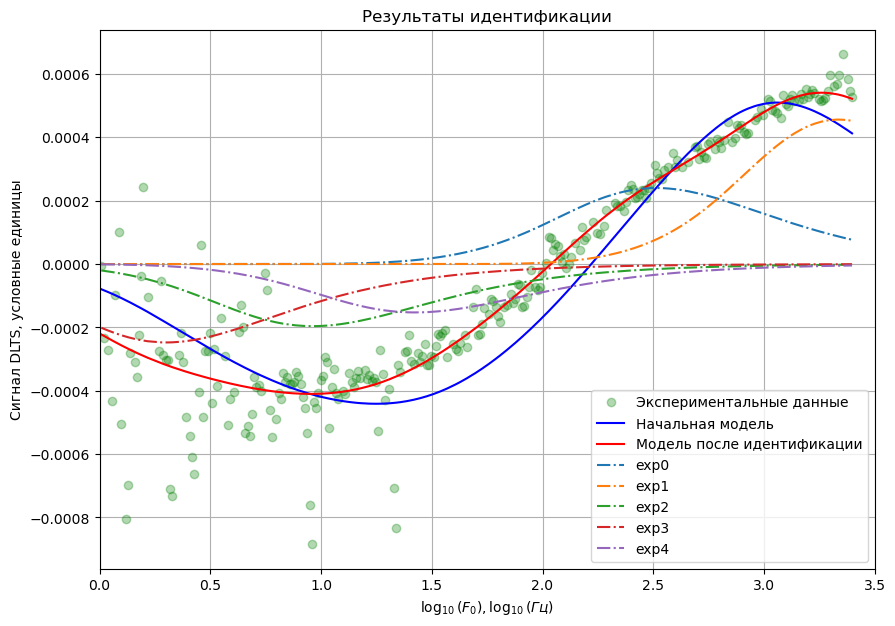

In [73]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.show()

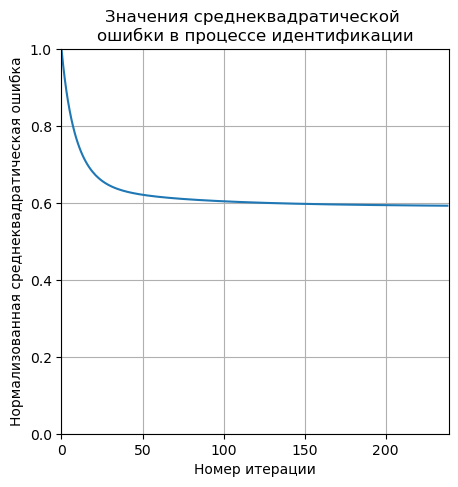

In [74]:
plot_loss_path(fit_results_)
plt.show()

In [75]:
y_pred = multiexp_fs.predict(X_train)

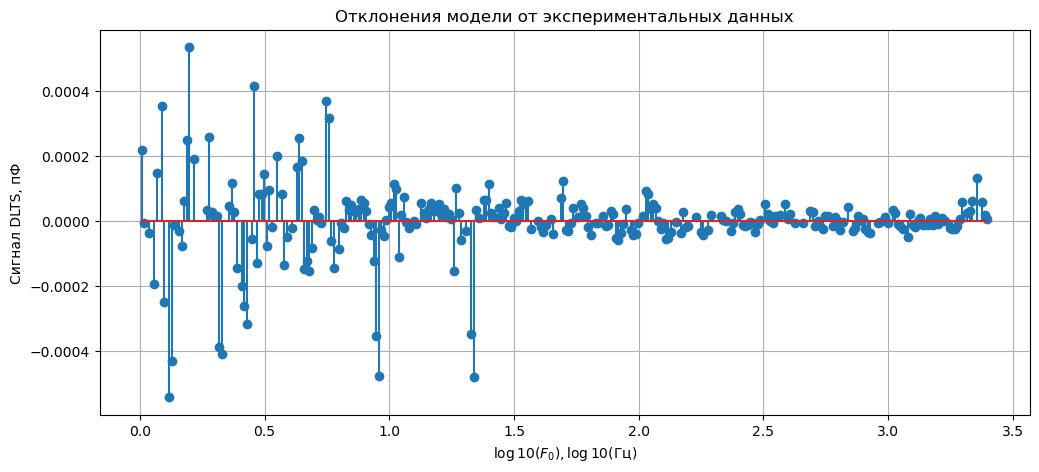

In [76]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.show()

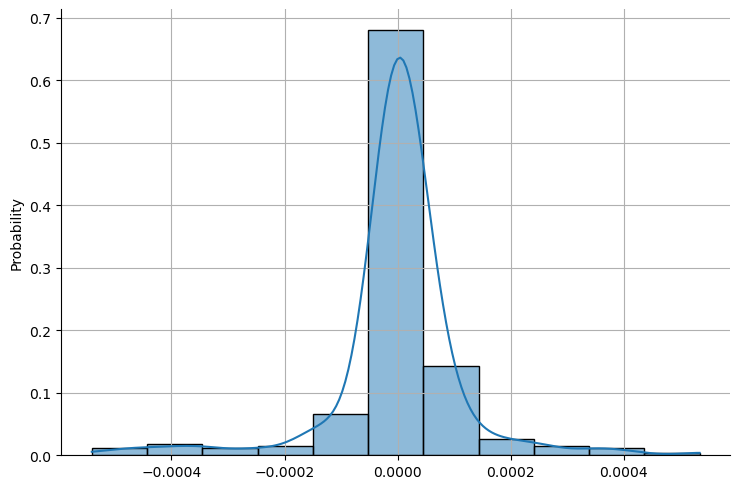

In [77]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()

plt.show()

In [78]:
scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=initial_exps_params), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 14:37:38.225206: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 14:37:38.225228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 14:37:38.225232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 14:37:38.225330: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 14:37:38.225343: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 14:37:38.225346: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 14:37:38.225451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.000117   0.00010608 0.00015213 0.00011855 0.00010502]
Mean: 0.00011975772491603178
Standard deviation: 1.709741889312256e-05


In [79]:
mean_squared_error(y_train, y_pred, squared=False)

0.00011511068462328718

In [80]:
mean_squared_error(y_test, multiexp_fs.predict(X_test), squared=False)

0.00018630582770078026

Выведем на экран полученный спектр

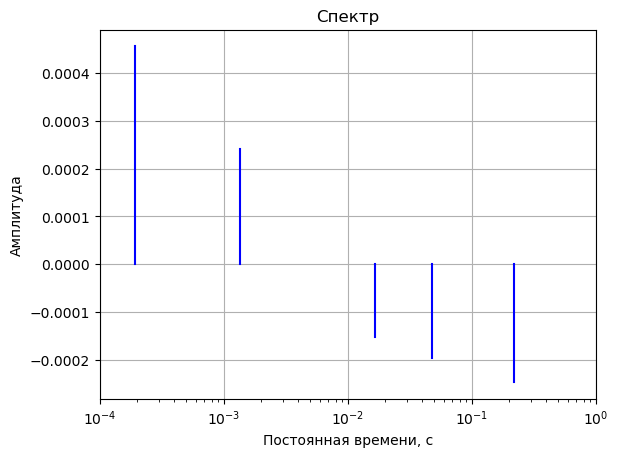

In [81]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.show()

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

Чтение данных

In [82]:
print(data_frames[1][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


In [83]:
filling_pulse, X_train, y_train, X_test, y_test = get_X_y(data_frames[1][1])

Выведем тренировачный набор данных

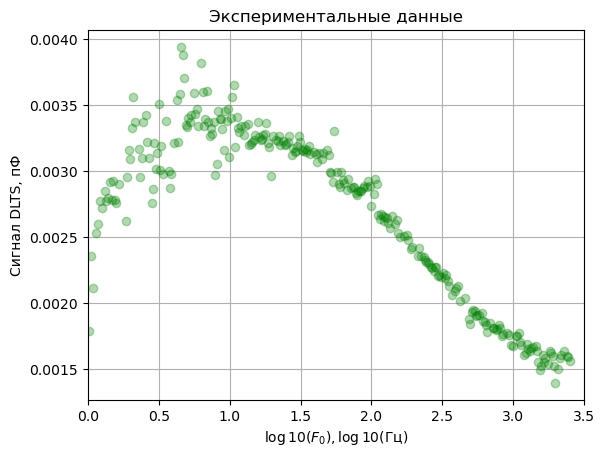

In [84]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_train_data.pdf',
            bbox_inches='tight')
plt.show()

Выведем тестовый набор данных

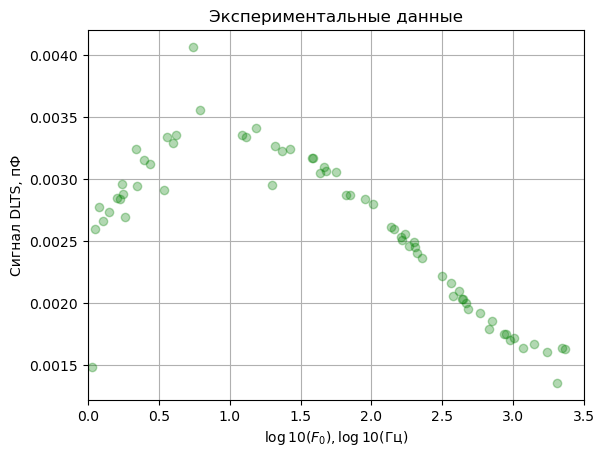

In [85]:
fig, ax = plot_experimental_points(X_test, y_test)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_test_data.pdf',
            bbox_inches='tight')
plt.show()

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

Идентификация модели:

In [86]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [87]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pkl']

Вывод табличных результатов идентификации

In [88]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_fit_results.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
123,0.003433,0.00001,True,0.05,2.440224e-08,1,1000,0.169940,0.00001,-1.254655,False
124,0.003434,0.00001,True,0.05,2.437955e-08,1,1000,0.170083,0.00001,-1.254753,False
125,0.003435,0.00001,True,0.05,2.435843e-08,1,1000,0.170222,0.00001,-1.254850,False
126,0.003436,0.00001,True,0.05,2.433875e-08,1,1000,0.170355,0.00001,-1.254946,False
127,0.003437,0.00001,True,0.05,2.432043e-08,1,1000,0.170485,0.00001,-1.255040,False
128,0.003438,0.00001,True,0.05,2.430336e-08,1,1000,0.170610,0.00001,-1.255134,False
129,0.003439,0.00001,True,0.05,2.428747e-08,1,1000,0.170731,0.00001,-1.255225,False
130,0.003440,0.00001,True,0.05,2.427267e-08,1,1000,0.170847,0.00001,-1.255316,False
131,0.003441,0.00001,True,0.05,2.425888e-08,1,1000,0.170960,0.00001,-1.255405,False
132,0.003441,0.00001,True,0.05,2.424604e-08,1,1000,0.171069,0.00001,-1.255492,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

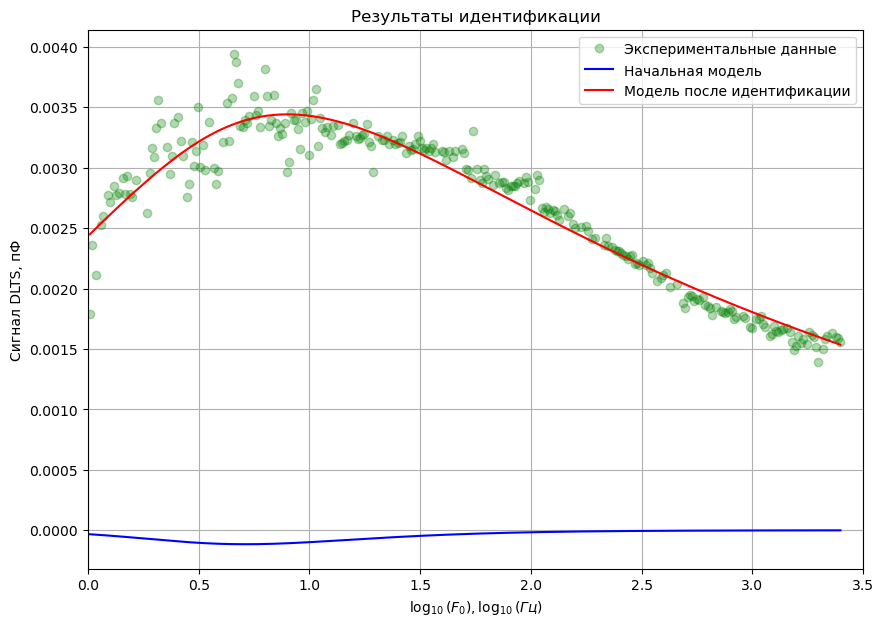

In [89]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

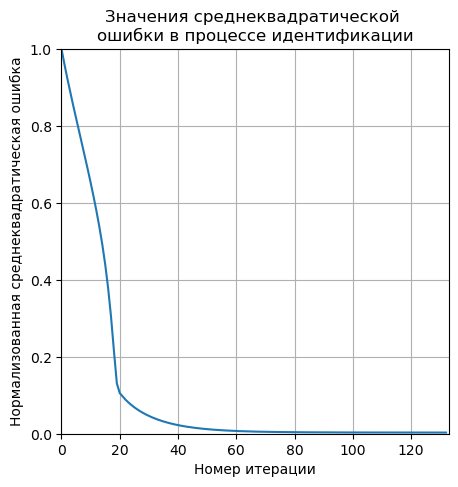

In [90]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

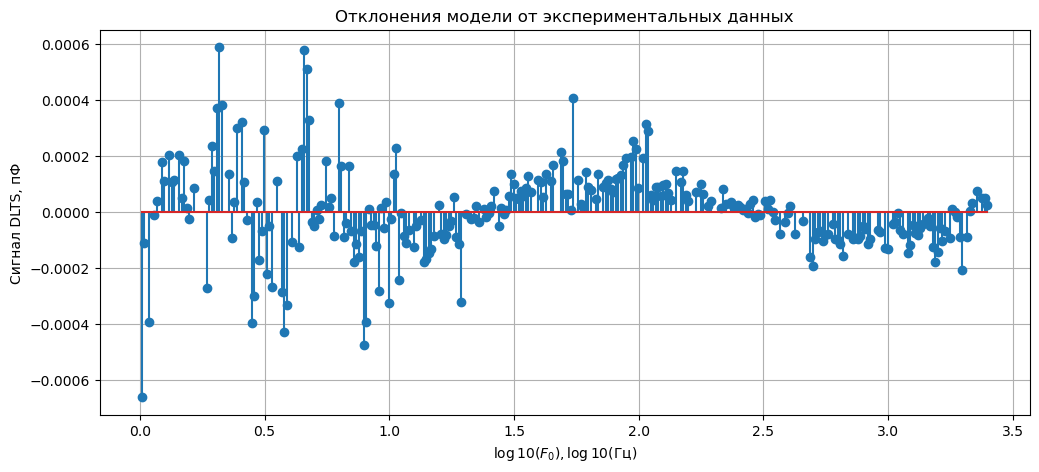

In [91]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

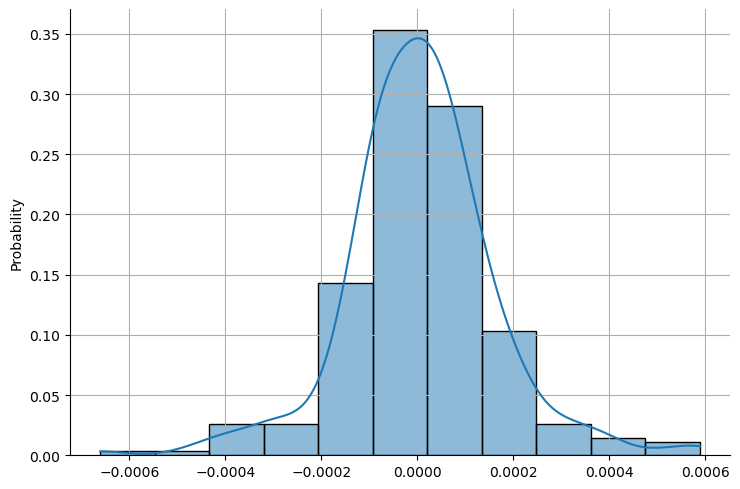

In [92]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [93]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train,
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 14:40:52.737360: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 14:40:52.737381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 14:40:52.737386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 14:40:52.737492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 14:40:52.737505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 14:40:52.737508: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 14:40:52.737615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00014885 0.00014937        nan 0.00016294        nan]
Mean: nan
Standard deviation: nan


/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_t

Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [94]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00015571140625004497

Оценим ту же метрику на тестовых данных

In [95]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00018281015509785008

Выведем на экран полученный спектр

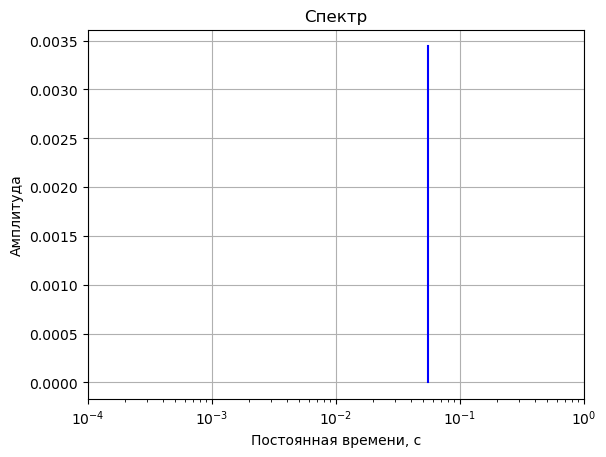

In [96]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 3.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [97]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [98]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [99]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
174,0.004471,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372391,False
175,0.004472,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372393,False
176,0.004473,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372394,False
177,0.004474,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372396,False
178,0.004475,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372397,False
179,0.004476,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372399,False
180,0.004477,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372400,False
181,0.004478,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372401,False
182,0.004479,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372403,False
183,0.004479,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372404,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

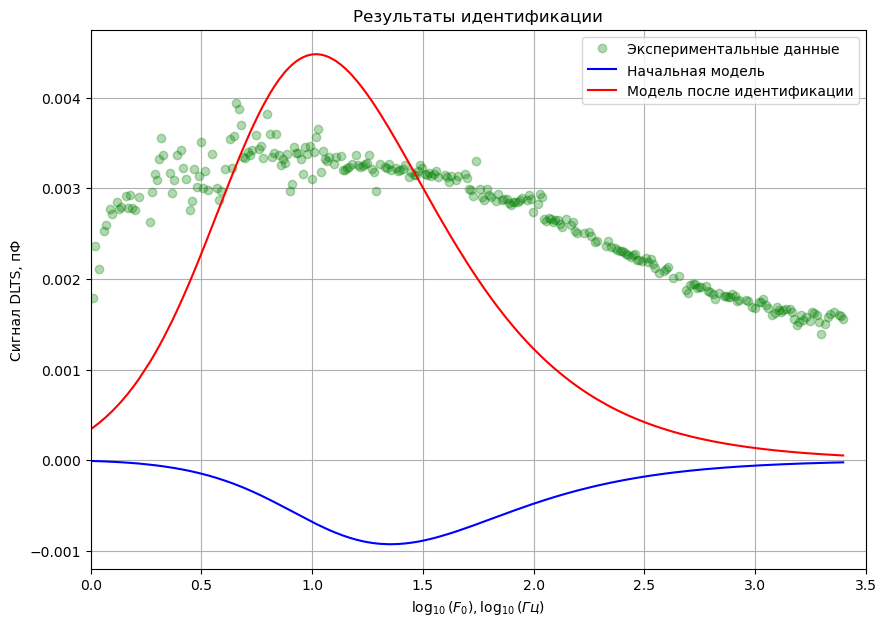

In [100]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

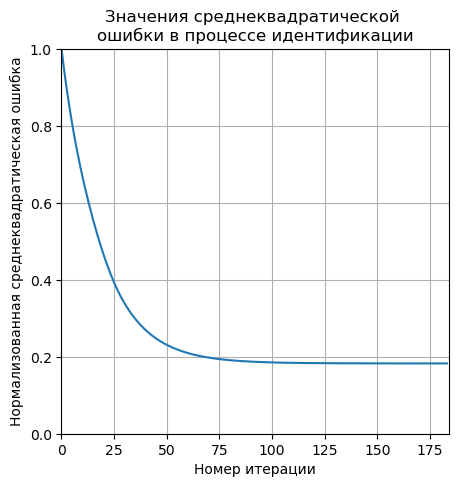

In [101]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

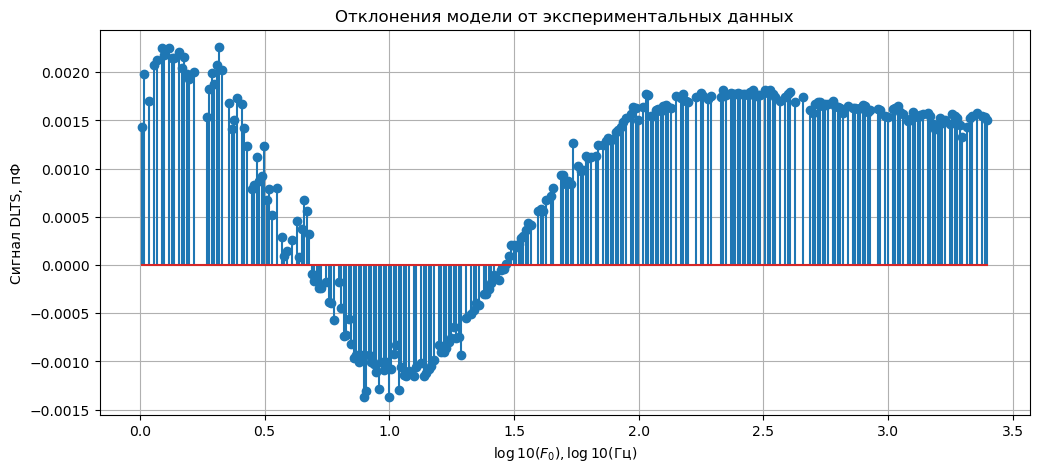

In [102]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

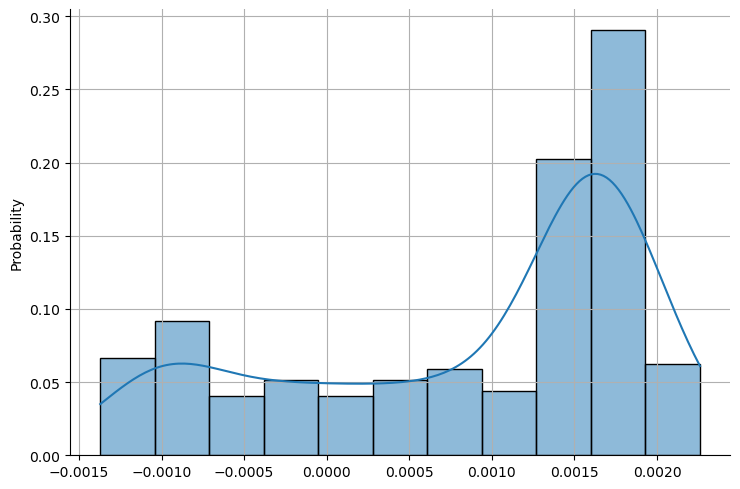

In [103]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [104]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.00140746 0.0013132  0.00136858 0.0013989  0.00142147]
Mean: 0.0013819216084260864
Standard deviation: 3.848165660735009e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [105]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0013669761064506614

Оценим ту же метрику на тестовых данных

In [106]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.0014868926636181713

Выведем на экран полученный спектр

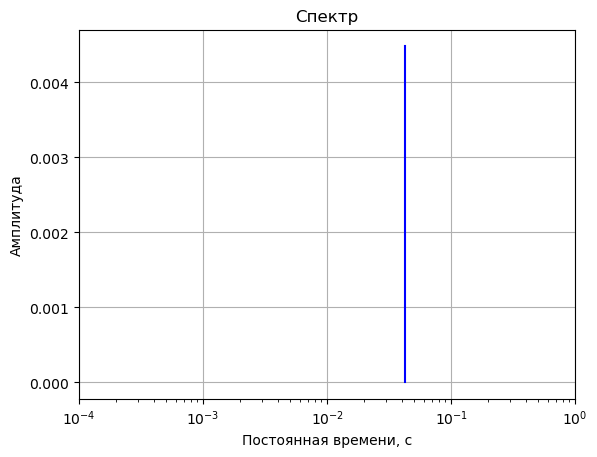

In [107]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [108]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [109]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [110]:
grid_search.fit(X_train, y_train)

2022-10-08 14:45:03.517434: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 14:45:03.517462: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 14:45:03.517472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 14:45:03.517694: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 14:45:03.517719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 14:45:03.517725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 14:45:03.517924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [111]:
grid_search.best_params_

{'n_exps': 7}

Сохраним объект GridSearchCV

In [112]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [113]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.001382444574638715 {'n_exps': 1}
0.0005734802987879456 {'n_exps': 2}
0.00024341023827650264 {'n_exps': 3}
0.00016332635771194697 {'n_exps': 4}
0.00015528599966626347 {'n_exps': 5}
0.0001524557180836555 {'n_exps': 6}
0.00014779064006827726 {'n_exps': 7}
0.00014904220304906817 {'n_exps': 8}
0.000149979200957923 {'n_exps': 9}
0.00014874529279600685 {'n_exps': 10}


Сохраним лучшую модель

In [114]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [115]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,filling_pulse,learning_rate,loss,...,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,verbose
376,0.001185,0.000816,0.000845,0.002841,0.000553,0.000726,0.000913,0.00001,0.05,2.158661e-08,...,1000,0.00001,-1.434143,-2.544178,-2.237444,-0.707754,-3.235156,-3.568611,-1.811139,False
377,0.001185,0.000817,0.000845,0.002840,0.000553,0.000726,0.000914,0.00001,0.05,2.157267e-08,...,1000,0.00001,-1.434133,-2.544266,-2.237652,-0.707711,-3.235129,-3.569212,-1.811001,False
378,0.001186,0.000817,0.000845,0.002840,0.000553,0.000726,0.000914,0.00001,0.05,2.155879e-08,...,1000,0.00001,-1.434124,-2.544354,-2.237858,-0.707669,-3.235101,-3.569810,-1.810862,False
379,0.001186,0.000817,0.000845,0.002840,0.000553,0.000726,0.000914,0.00001,0.05,2.154498e-08,...,1000,0.00001,-1.434116,-2.544443,-2.238063,-0.707626,-3.235073,-3.570408,-1.810722,False
380,0.001186,0.000817,0.000845,0.002840,0.000553,0.000727,0.000914,0.00001,0.05,2.153124e-08,...,1000,0.00001,-1.434107,-2.544532,-2.238267,-0.707583,-3.235044,-3.571003,-1.810583,False
381,0.001186,0.000817,0.000845,0.002840,0.000553,0.000727,0.000914,0.00001,0.05,2.151756e-08,...,1000,0.00001,-1.434099,-2.544621,-2.238471,-0.707540,-3.235014,-3.571597,-1.810444,False
382,0.001186,0.000818,0.000845,0.002840,0.000553,0.000727,0.000914,0.00001,0.05,2.150395e-08,...,1000,0.00001,-1.434091,-2.544711,-2.238673,-0.707497,-3.234984,-3.572190,-1.810304,False
383,0.001186,0.000818,0.000845,0.002840,0.000553,0.000727,0.000914,0.00001,0.05,2.149040e-08,...,1000,0.00001,-1.434083,-2.544801,-2.238874,-0.707454,-3.234953,-3.572781,-1.810165,False
384,0.001186,0.000818,0.000845,0.002840,0.000553,0.000727,0.000914,0.00001,0.05,2.147692e-08,...,1000,0.00001,-1.434075,-2.544891,-2.239075,-0.707411,-3.234922,-3.573370,-1.810025,False
385,0.001187,0.000818,0.000845,0.002839,0.000553,0.000727,0.000914,0.00001,0.05,2.146351e-08,...,1000,0.00001,-1.434068,-2.544981,-2.239274,-0.707367,-3.234890,-3.573958,-1.809885,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

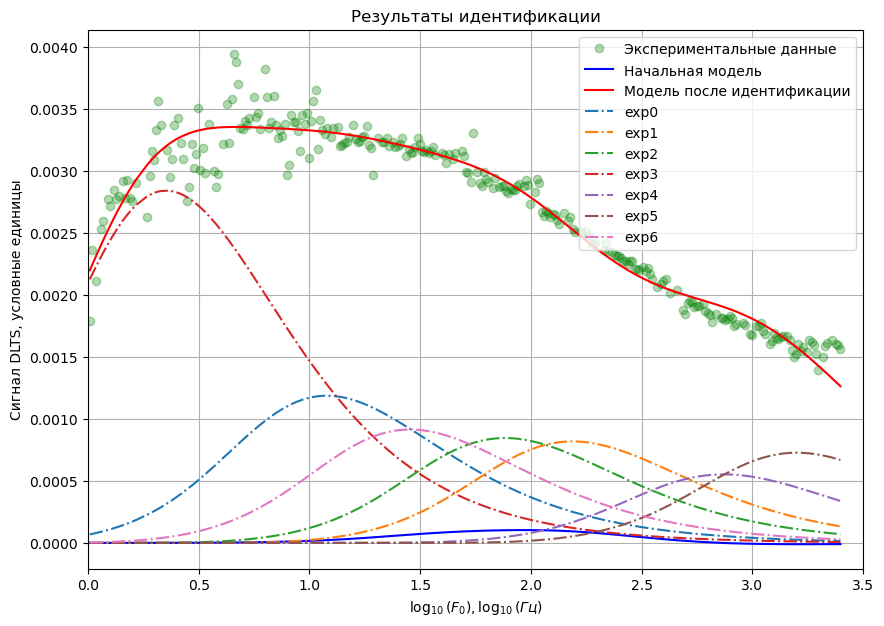

In [116]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

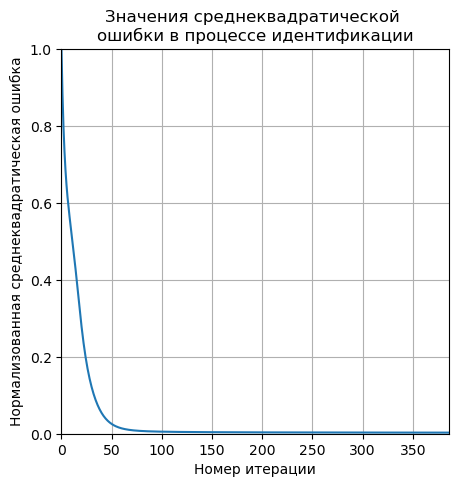

In [117]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [118]:
y_pred = multiexp_fs.predict(X_train)

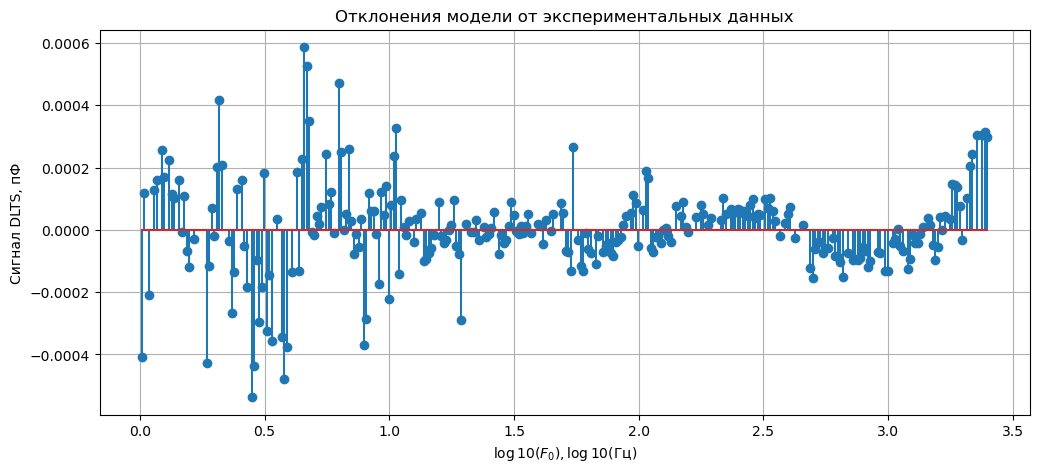

In [119]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

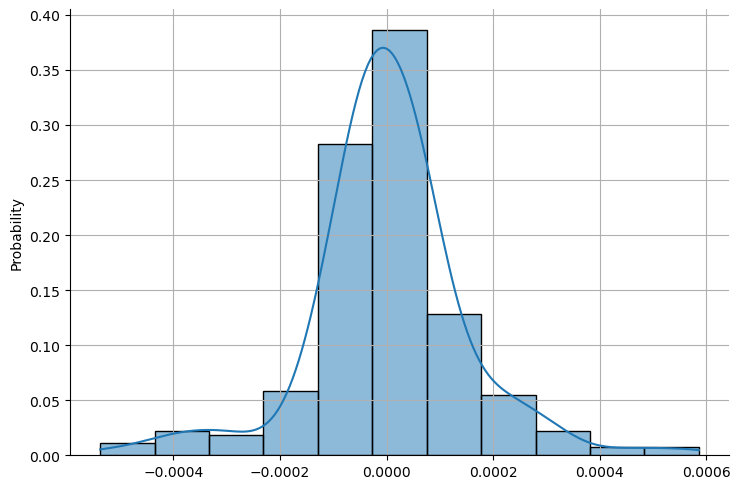

In [120]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [121]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 15:14:06.683505: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 15:14:06.683526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 15:14:06.683530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 15:14:06.683633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 15:14:06.683645: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 15:14:06.683649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 15:14:06.683751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00012803 0.00014367 0.00016672 0.00015244 0.00016611]
Mean: 0.00015139159293106136
Standard deviation: 1.4547765657743438e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [122]:
mean_squared_error(y_train, y_pred, squared=False)

0.00014650430070817417

Оценим ту же метрику на тестовых данных

In [123]:
mean_squared_error(y_test, multiexp_fs.predict(X_test), squared=False)

0.00018197394417212868

Выведем на экран полученный спектр

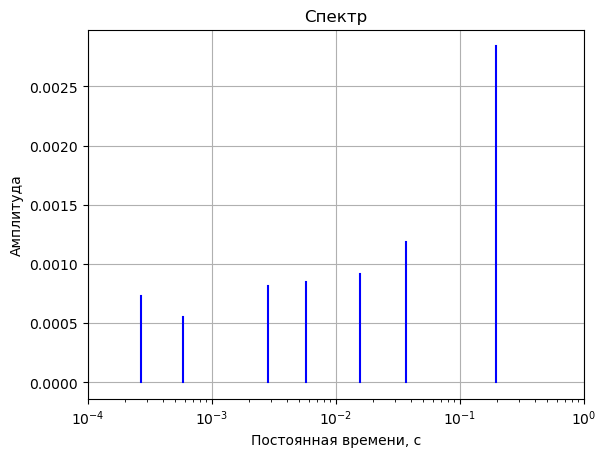

In [124]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

## 4. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_+30С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 4.1. Подготовка экспериментальных данных

Чтение данных

In [125]:
print(data_frames[2][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


In [126]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    dataset = dataset.sample(frac=1, random_state=42)
    
    X_train = np.log10(dataset.frequency_hz.to_numpy())
    y_train = dataset.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train


filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])

Выведем тренировачный набор данных

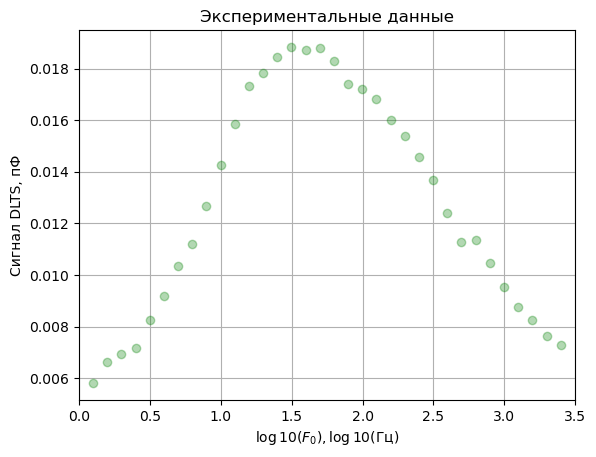

In [127]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_train_data.pdf',
            bbox_inches='tight')
plt.show()

### 4.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [128]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [129]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pkl']

Вывод табличных результатов идентификации

In [130]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_fit_results.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
148,0.018478,0.00001,True,0.05,4.393927e-07,1,1000,0.274442,0.00001,-1.920539,False
149,0.018483,0.00001,True,0.05,4.389125e-07,1,1000,0.274590,0.00001,-1.920511,False
150,0.018488,0.00001,True,0.05,4.384588e-07,1,1000,0.274734,0.00001,-1.920485,False
151,0.018492,0.00001,True,0.05,4.380300e-07,1,1000,0.274874,0.00001,-1.920459,False
152,0.018497,0.00001,True,0.05,4.376248e-07,1,1000,0.275010,0.00001,-1.920433,False
153,0.018501,0.00001,True,0.05,4.372419e-07,1,1000,0.275143,0.00001,-1.920409,False
154,0.018505,0.00001,True,0.05,4.368800e-07,1,1000,0.275271,0.00001,-1.920385,False
155,0.018509,0.00001,True,0.05,4.365380e-07,1,1000,0.275396,0.00001,-1.920362,False
156,0.018513,0.00001,True,0.05,4.362148e-07,1,1000,0.275518,0.00001,-1.920340,False
157,0.018517,0.00001,True,0.05,4.359094e-07,1,1000,0.275636,0.00001,-1.920318,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

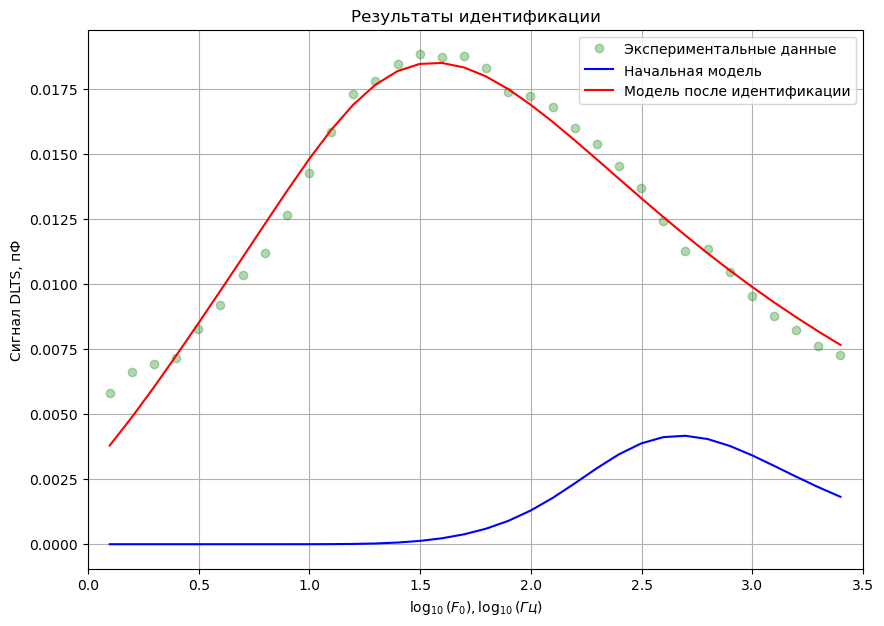

In [131]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

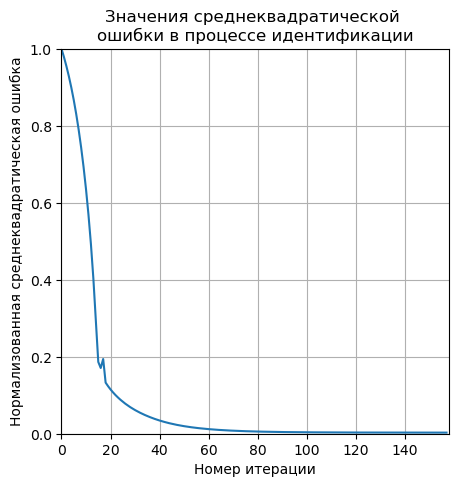

In [132]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

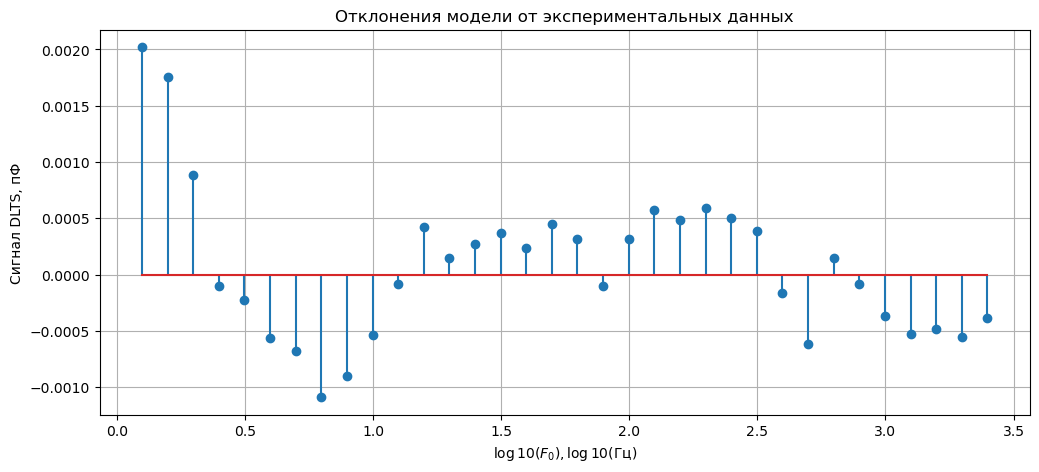

In [133]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

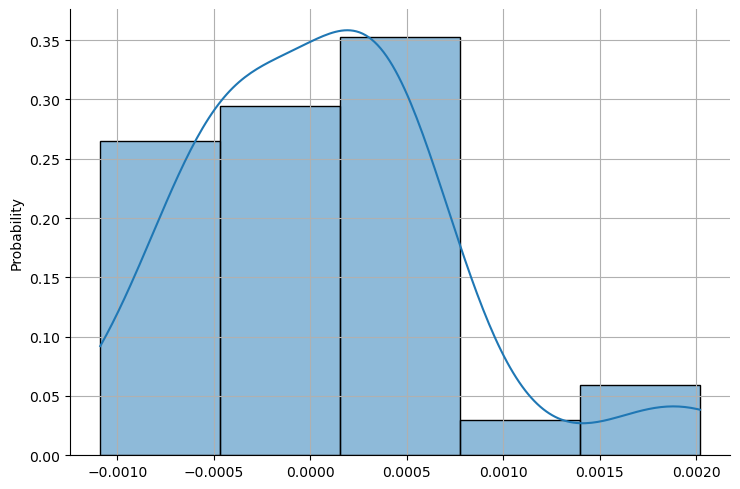

In [134]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [135]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train,
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.00071353 0.00080735 0.0005521  0.00052731 0.00096502]
Mean: 0.0007130630114081864
Standard deviation: 0.00016296323493374934


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [136]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0006602343518253575

Выведем на экран полученный спектр

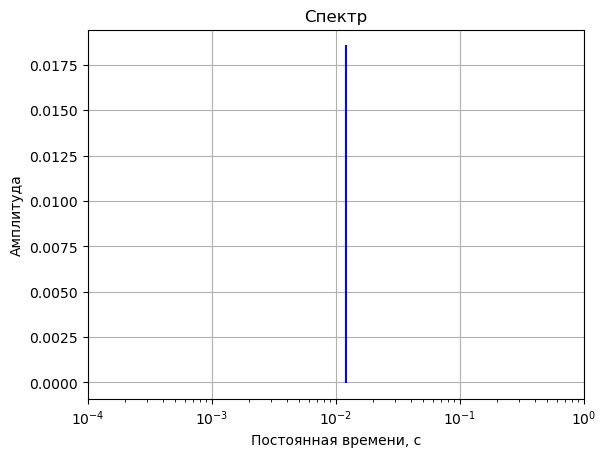

In [137]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 4.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [138]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [139]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [140]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
182,0.023801,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931466,False
183,0.023806,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931467,False
184,0.023811,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931468,False
185,0.023815,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931469,False
186,0.023820,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931470,False
187,0.023824,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931471,False
188,0.023828,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931472,False
189,0.023832,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931473,False
190,0.023836,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931473,False
191,0.023840,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931474,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

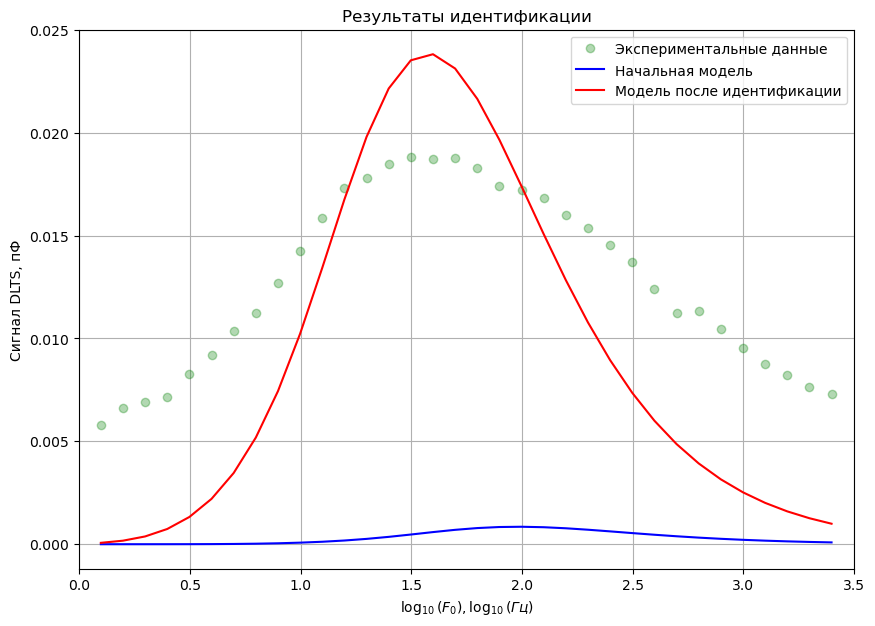

In [141]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

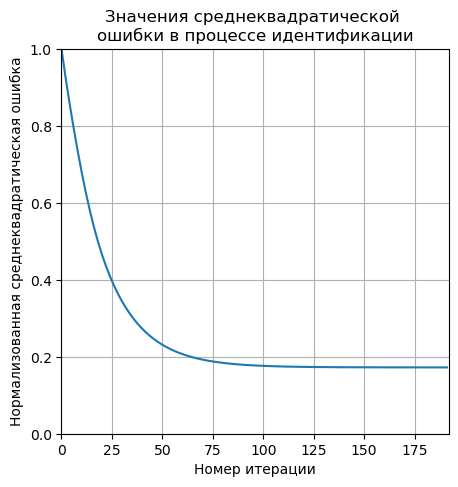

In [142]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

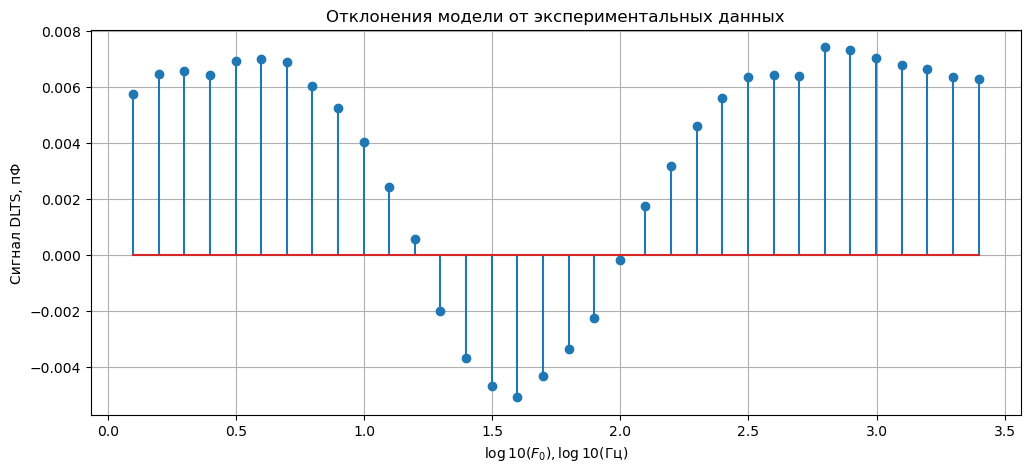

In [143]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

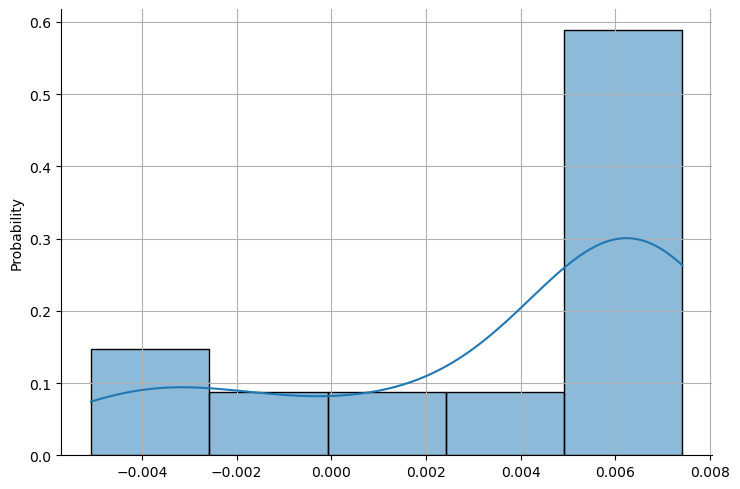

In [144]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [145]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 15:21:58.878996: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 15:21:58.879025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 15:21:58.879035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 15:21:58.879146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 15:21:58.879161: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 15:21:58.879165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 15:21:58.879280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00550633 0.00555716 0.00642198 0.00622873 0.00547312]
Mean: 0.005837462444262933
Standard deviation: 0.0004039108785696621


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [146]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0054364615185902194

Выведем на экран полученный спектр

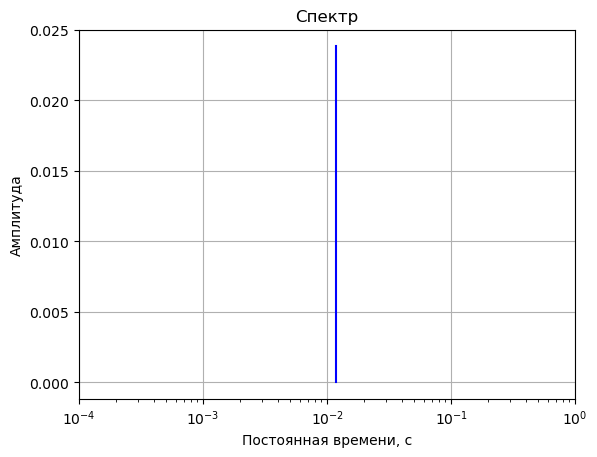

In [147]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 4.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [148]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [149]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [150]:
grid_search.fit(X_train, y_train)

2022-10-08 15:22:29.101460: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 15:22:29.101485: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 15:22:29.101489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 15:22:29.101683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 15:22:29.101696: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 15:22:29.101700: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 15:22:29.101894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [151]:
grid_search.best_params_

{'n_exps': 9}

Сохраним объект GridSearchCV

In [152]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [153]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.005851367430126204 {'n_exps': 1}
0.0027436877803440093 {'n_exps': 2}
0.001297015505577217 {'n_exps': 3}
0.0006876257251836591 {'n_exps': 4}
0.0006029854980383814 {'n_exps': 5}
0.0005132092676825015 {'n_exps': 6}
0.00040355272508662567 {'n_exps': 7}
0.0004730871729566063 {'n_exps': 8}
0.0003683416726681501 {'n_exps': 9}
0.0004560678424811704 {'n_exps': 10}


Сохраним лучшую модель

In [154]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [155]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,amplitude_8,filling_pulse,...,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,time_constant_pow_8,verbose
236,0.003284,0.004839,0.004172,0.004571,0.002618,0.005698,0.004057,0.003998,0.003215,0.00001,...,-2.603568,-1.659413,-1.492720,-1.923740,-2.656210,-0.680266,-1.972078,-3.623785,-2.867868,False
237,0.003283,0.004839,0.004172,0.004571,0.002617,0.005699,0.004057,0.004001,0.003215,0.00001,...,-2.603445,-1.659453,-1.492691,-1.923788,-2.656145,-0.679975,-1.972106,-3.624108,-2.868022,False
238,0.003283,0.004839,0.004172,0.004571,0.002617,0.005701,0.004058,0.004004,0.003215,0.00001,...,-2.603324,-1.659492,-1.492662,-1.923836,-2.656080,-0.679688,-1.972135,-3.624428,-2.868175,False
239,0.003283,0.004840,0.004172,0.004572,0.002617,0.005702,0.004058,0.004006,0.003214,0.00001,...,-2.603203,-1.659530,-1.492633,-1.923883,-2.656015,-0.679403,-1.972163,-3.624746,-2.868325,False
240,0.003283,0.004840,0.004173,0.004572,0.002616,0.005703,0.004058,0.004009,0.003214,0.00001,...,-2.603084,-1.659566,-1.492604,-1.923930,-2.655951,-0.679122,-1.972191,-3.625061,-2.868474,False
241,0.003282,0.004840,0.004173,0.004572,0.002616,0.005705,0.004059,0.004012,0.003214,0.00001,...,-2.602965,-1.659602,-1.492574,-1.923976,-2.655888,-0.678844,-1.972220,-3.625374,-2.868621,False
242,0.003282,0.004840,0.004173,0.004572,0.002616,0.005706,0.004059,0.004014,0.003214,0.00001,...,-2.602848,-1.659636,-1.492545,-1.924023,-2.655824,-0.678569,-1.972249,-3.625685,-2.868767,False
243,0.003282,0.004840,0.004173,0.004573,0.002616,0.005707,0.004059,0.004017,0.003213,0.00001,...,-2.602731,-1.659669,-1.492515,-1.924069,-2.655761,-0.678298,-1.972277,-3.625993,-2.868910,False
244,0.003282,0.004841,0.004173,0.004573,0.002615,0.005709,0.004060,0.004020,0.003213,0.00001,...,-2.602616,-1.659702,-1.492485,-1.924115,-2.655699,-0.678029,-1.972306,-3.626298,-2.869052,False
245,0.003281,0.004841,0.004174,0.004573,0.002615,0.005710,0.004060,0.004022,0.003213,0.00001,...,-2.602501,-1.659733,-1.492455,-1.924160,-2.655637,-0.677763,-1.972335,-3.626601,-2.869192,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

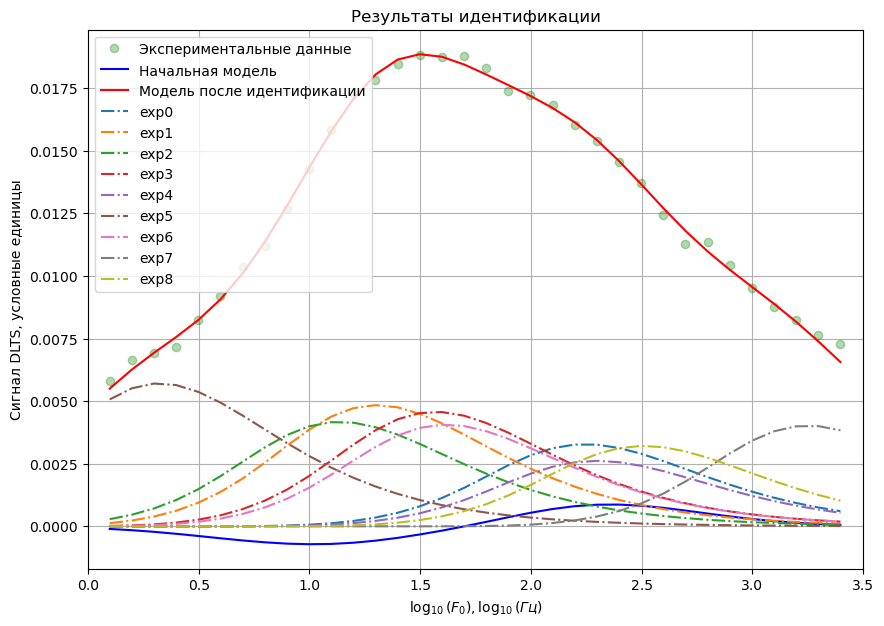

In [156]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

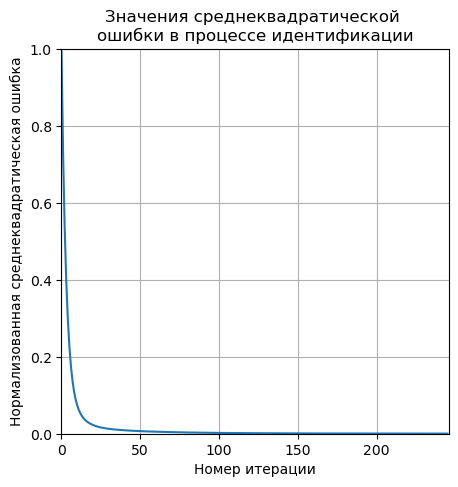

In [157]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [158]:
y_pred = multiexp_fs.predict(X_train)

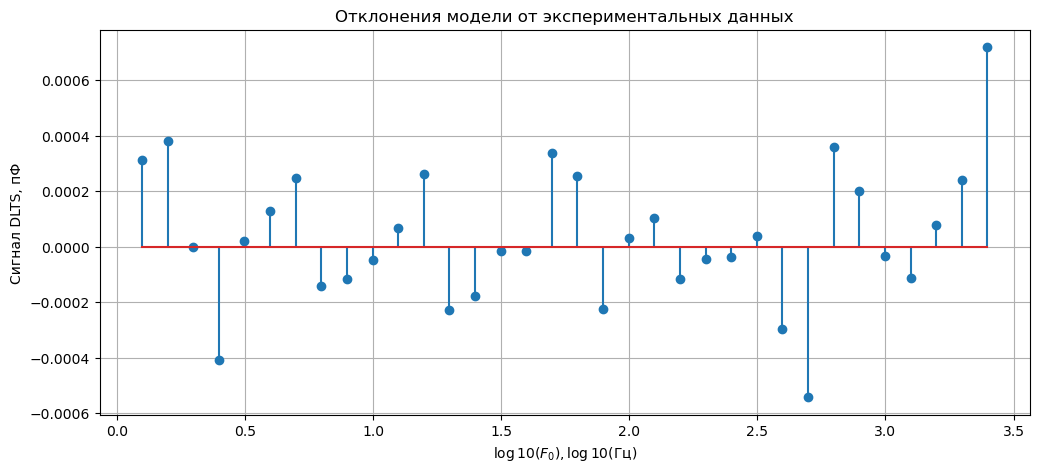

In [159]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

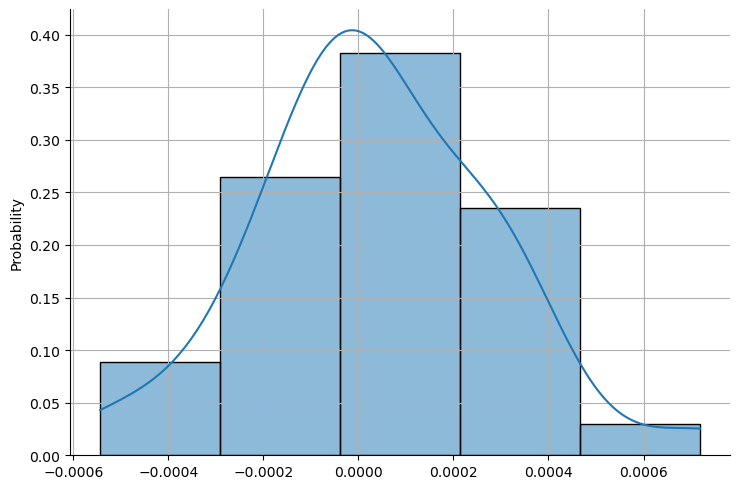

In [164]:
sns.displot(x=y_train - y_pred, bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [161]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 16:03:45.223501: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 16:03:45.223524: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 16:03:45.223534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 16:03:45.223635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 16:03:45.223648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 16:03:45.223651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 16:03:45.223761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.0002337  0.00060727 0.00051334 0.00036297 0.00050404]
Mean: 0.00044426402320420775
Standard deviation: 0.00013104167465048251


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [162]:
mean_squared_error(y_train, y_pred, squared=False)

0.0002475649619404401

Выведем на экран полученный спектр

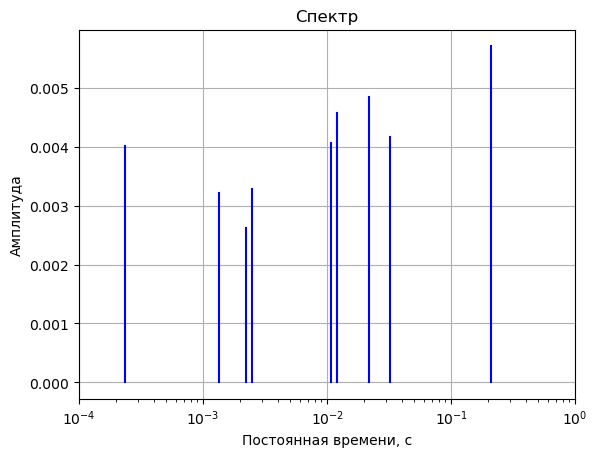

In [163]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()